Compare time- and spatially averaged NextSim model output to CS2SMOS before the ice break-up occurs (i.e. start-Feb 2013)

In [22]:
# allow plots to be interactive in the notebook
%matplotlib notebook

import numpy as np
import datetime as dt
import pynextsim.openers as pnops
import mod_netcdf_utils as mnu
import pynextsim.gridding as png
from pynextsim.netcdf_list import NetcdfList
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator
import matplotlib.pyplot as plt
from pynextsim.nextsim_bin import NextsimBin as nb
import os 
import sys
import matplotlib.colors as colors
from cartopy import config
import cartopy.crs as ccrs
import pyproj

In [51]:
# open Morrings from Nextsim output

outpath = 'data/'
outpath_plots = 'plots/'

# specify model data directory
fl = '/cluster/work/users/rheinlender/breakup2013/outputs/breakup2013.ERA5.r10_v2/'

opener_moorings = pnops.OpenerNextsimMoorings(fl)
moorings = NetcdfList([fl+'Moorings_2013m02.nc'])
print(moorings.datetimes)

# create time array for fetching data
dto = dt.datetime(2013,2,1,6,0)
dto2 = dt.datetime(2013,2,3,18,0)
delta = dto - dto2

datelist = [dto.strftime('%Y-%m-%d %H:%M:%S')]
while dto < dto2:
    dto += dt.timedelta(hours=12)
    datelist.append(dto.strftime('%Y-%m-%d %H:%M:%S'))

datelist = [dt.datetime.strptime(s, "%Y-%m-%d %H:%M:%S") for s in datelist]

print(dates)
# prepare input 
nx,ny = moorings.get_var(dto, 'Thickness').shape
nt = len(date_list)
print(nt,nx,ny)

nsit = np.zeros((nt,nx,ny))
nsic = np.zeros((nt,nx,ny))

# get Nextsim ice thickness and conc
for n in range(len(datelist)):
    nsit[n, :,:] = moorings.get_var(datelist[n], 'Thickness') # get nextsim ice thickness
    nsic[n,:,:] =  moorings.get_var(datelist[n], 'Concentration') 

nsit=nsit.mean(axis=0)
nsic=nsic.mean(axis=0)

[datetime.datetime(2013, 2, 1, 6, 0), datetime.datetime(2013, 2, 1, 18, 0), datetime.datetime(2013, 2, 2, 6, 0), datetime.datetime(2013, 2, 2, 18, 0), datetime.datetime(2013, 2, 3, 6, 0), datetime.datetime(2013, 2, 3, 18, 0), datetime.datetime(2013, 2, 4, 6, 0), datetime.datetime(2013, 2, 4, 18, 0), datetime.datetime(2013, 2, 5, 6, 0), datetime.datetime(2013, 2, 5, 18, 0), datetime.datetime(2013, 2, 6, 6, 0), datetime.datetime(2013, 2, 6, 18, 0), datetime.datetime(2013, 2, 7, 6, 0), datetime.datetime(2013, 2, 7, 18, 0), datetime.datetime(2013, 2, 8, 6, 0), datetime.datetime(2013, 2, 8, 18, 0), datetime.datetime(2013, 2, 9, 6, 0), datetime.datetime(2013, 2, 9, 18, 0), datetime.datetime(2013, 2, 10, 6, 0), datetime.datetime(2013, 2, 10, 18, 0), datetime.datetime(2013, 2, 11, 6, 0), datetime.datetime(2013, 2, 11, 18, 0), datetime.datetime(2013, 2, 12, 6, 0), datetime.datetime(2013, 2, 12, 18, 0), datetime.datetime(2013, 2, 13, 6, 0), datetime.datetime(2013, 2, 13, 18, 0), datetime.datetim

In [52]:
# get cs2smos variables on neXtSIM mesh elements

obs_inpath = '/cluster/projects/nn2993k/sim/data/CS2_SMOS_v2.0/'
obs_file = obs_inpath + 'awi-cs2smos-l4-sithick-cryosat2_smos_merged-rep-nh25km_ease2-20130128_20130203-fv2p0.nc'

# Fix - variable names to be consistent with nc file  
o = pnops.OpenerCs2SmosThick()
o.variables['Thickness'].name = 'analysis_ice_thickness'
o.variables['Thickness_Uncertainty'].name = 'analysis_thickness_unc'
o.variables['Concentration'].name = 'ice_conc'

# get bounding box from model (i.e. small_arctic_10km)
bbox = moorings.file_objects[0].get_bbox(o.projection.pyproj)

nci_obs = mnu.nc_getinfo(obs_file)
obs_grid = png.Grid.init_from_nc_getinfo(nci_obs, projection=o.projection, bbox=bbox)    #cs2smos grid
obs_vars = obs_grid.get_external_data(
                o.variables,
                dto,
                nci=nci_obs,
                data_on_same_grid=True, #we always use the obs grid
                allow_missing=True)


reduce grid bbox:  [-2584859.0247218814, 2714189.166638696, -2151842.919231681, 3139273.504268901]
Variable:  analysis_ice_thickness
Reading external data (on same grid)
Variable:  analysis_thickness_unc
Reading external data (on same grid)
Variable:  ice_conc
Reading external data (on same grid)


In [53]:
# interpolate model grid to observational grid (NB: slow)

lon, lat = moorings.file_objects[0].get_lonlat() 
xy_mod = obs_grid.projection.pyproj(lon, lat)    #model grid
irreg_grid_interp = IrregularGridInterpolator(*xy_mod, *obs_grid.xy)
print('Interpolation done')

# get model data on observational grid
nsiti = irreg_grid_interp.interp_field(nsit)
nsici = irreg_grid_interp.interp_field(nsic)


Interpolation done


<IPython.core.display.Javascript object>


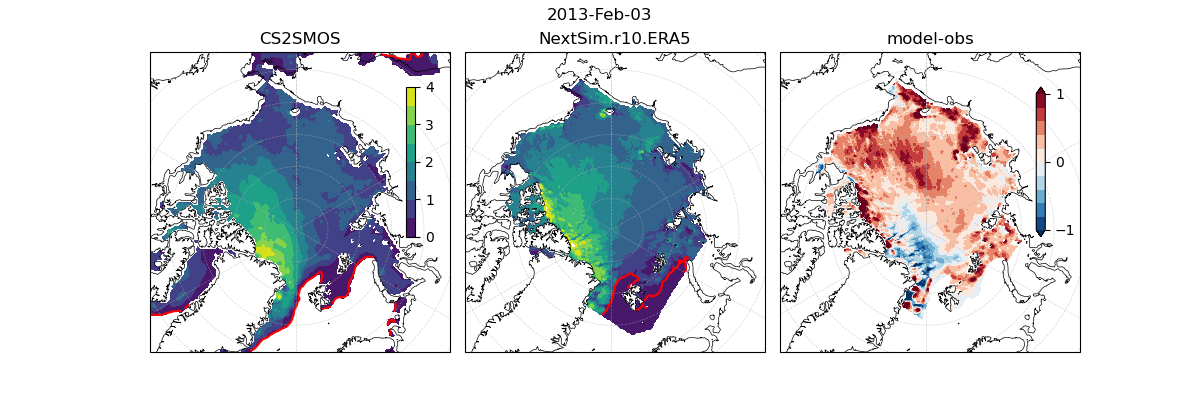

In [54]:
# Plot Mooring and observation using cartopy

def inset_colorbar(fig, ax, mappable, **kwargs):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    axins = inset_axes(ax,
                       width="3%",  # width = 50% of parent_bbox width
                       height="50%",  # height : 5%
                       loc='upper right',
                       #bbox_to_anchor=(1.05, 0., 1, 1),
                       #bbox_transform=ax.transAxes,
                       borderpad=2.5,
                       )

    cbar = fig.colorbar(mappable, cax=axins, orientation="vertical", **kwargs)
    
    # Controlling the placement of the inset axes is basically same as that
    # of the legend.  you may want to play with the borderpad value and
    # the bbox_to_anchor coordinate.
    return cbar

plt.close('all')
# get x and y coordinates from observation grid
x=obs_grid.xy[0]
y=obs_grid.xy[1]

# get projection info from model
mproj = pyproj.Proj(moorings.file_objects[0].proj_info.proj4_string)

# make discrete colormap
levels = np.arange(0., 4.5, .5)
bounds=np.linspace(0,4,9)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig = plt.figure(figsize=(12,4))

# observation
ax1 = plt.subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('CS2SMOS')

ax1.coastlines(resolution='50m', linewidth=0.5)
ax1.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax1.set_extent(bbox, crs=ccrs.NorthPolarStereo())

cs1 = ax1.contourf(obs_vars['Thickness'], origin='upper', extent=bbox, levels=levels,
               transform=ccrs.NorthPolarStereo())

line_c = ax1.contour(x, y, obs_vars['Concentration'],colors=['red'], levels=[0.3], 
               transform=ccrs.NorthPolarStereo())

# model
ax2 = plt.subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('NextSim.r10.ERA5')

ax2.coastlines(resolution='50m', linewidth=0.5)
ax2.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax2.set_extent(bbox, crs=ccrs.NorthPolarStereo())

cs2 = ax2.contourf(nsiti, origin='upper', extent=bbox, levels=levels, 
               transform=ccrs.NorthPolarStereo())

line_c2 = ax2.contour(x, y, nsici,colors=['red'], levels=[0.3], 
               transform=ccrs.NorthPolarStereo())
# model-observation
ax3 = plt.subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(central_longitude=0))
plt.title('model-obs')

ax3.coastlines(resolution='50m', linewidth=0.5)
ax3.gridlines(linewidth=0.5, alpha=0.5, linestyle='--')
ax3.set_extent(bbox, crs=ccrs.NorthPolarStereo())

cs3 = ax3.contourf(nsiti-obs_vars['Thickness'], origin='upper', extent=bbox,
               transform=ccrs.NorthPolarStereo(),levels=np.arange(-1, 1.+0.2, 0.2), cmap='RdBu_r', extend='both')

# set colorbar and title
fig.suptitle(dto.strftime('%Y-%b-%d'))
cb1=inset_colorbar(fig,ax1,cs1)
cb1.set_ticks([0,1,2,3,4])
cb3=inset_colorbar(fig,ax3,cs3)
cb3.set_ticks([-1,0,1])
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.show()

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/python/plots/'
figname = outpath_plots+'sit_'+ dto.strftime('%Y-%b-%d') + '_cs2smos_nextsim.r10.era5_v2.png'
fig.savefig(figname, dpi=150, bbox_inches='tight')